# Function Definitions

In [40]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial

%matplotlib inline

#target = -1 + 2*x1 + 2*x2 #np.array([2,2,-1])
df = pd.DataFrame({'x1':[0,1,0,-0.5,-1,2,1,3,0.5,-1,0,-2,-3,1,2,-4,-3,3,-0.5,-2],
                   'x2':[0,1,1,0,-1,4,-1,-5,-2,1,3,0,-1,6,8,2,3,10,2,1], 
                   'y':[1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]})
df['x0'] = 1
df = df[['x0','x1', 'x2', 'y']]

def perceptron(points, dim, max_it=100, use_adaline=False, 
               eta = 1, randomize=False, print_out = True):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    num_points = points.shape[0]
    for it in range(max_it):
        correctly_predicted_ids=  set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error
                st = -100
            threshold = 1 if use_adaline else 0
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                break #PLA picks one example at each iteration
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break
    
    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod > 0:
            c +=1
    w = w/w[-1]
    if print_out:
        print('final correctness: ', c, '. Total iteration: ', it)
        print('final normalized w:', w)
    return w, it
    
def flip_coins(total_coins):
    """Flip all coins once, return their head/tail status
    """
    
    hts = np.zeros(total_coins) #head: 1, tail: 0
    probs = np.random.uniform(size=total_coins)
    hts[probs > 0.5] = 1
    return hts

def run_once(total_coins, total_flips, print_freq = False):
    v1, vrand, vmin = None, None, None
    crand = np.random.choice(total_coins)
    hts_sum = np.zeros(total_coins) # store the sum of heads in total_flips
    
    for flip in range(total_flips):
        hts_sum = hts_sum + flip_coins(total_coins)
    
    hts_freq = hts_sum/total_flips
    
    v1 = hts_freq[0]
    vrand = hts_freq[crand]
    cmin = np.argmin(hts_sum)
    vmin = hts_freq[cmin]
    
    if print_freq:
        print('Frequency of first coin: {}'.format(v1))
        print('Frequency of a random coin: id({})-freq({})'.format(crand, vrand))
        print('Frequency of the coin with minimum frequency: id({})-freq({})'.format(cmin, vmin))
    return v1,vrand,vmin

def hoeffding_bound(epsilon, n):
    return 2.0*np.exp(-2.0*n*epsilon**2)


def generate_random_numbers01(N, dim, num_grid_points):
    random_ints = np.random.randint(num_grid_points, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb)/(num_grid_points - 1 - init_lb)

def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    zero_to_one_points = generate_random_numbers01(N, dim, num_grid_points)
    res = lb + (ub - lb)*zero_to_one_points
    return res

def generate_random_coeffs(dim):
    rn = generate_random_numbers(1, dim, 1000, -10, 10)
    return rn

def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())

def generate_two_classes(N, dim, true_func, rn_func):
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_func(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_func(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)    

def generate_df(N, dim,true_func, rn_func):
    cls1, cls2 = generate_two_classes(N/2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df

def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
        figsize = plt.figaspect(1)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        cls1_df = df.loc[df['y']==1]
        cls2_df = df.loc[df['y']==-1]
        line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function')
        pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c= 'r', label='+1 labels')
        minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c= 'b', label='-1 labels')
        if norm_g is not None:
            hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

        ax.set_ylabel(r"$x_2$", fontsize=11)
        ax.set_xlabel(r"$x_1$", fontsize=11)
        ax.set_title('Data set size = %s'%N, fontsize=9)
        ax.axis('tight')
        legend_x = 2.0
        legend_y = 0.5
        ax.legend(['True Function', 'Final Hypothesis', 
                   '+1 labels', '-1 labels', ], 
                  loc='center right', bbox_to_anchor=(legend_x, legend_y))
        #ax.legend(handles=[pluses, minuses], fontsize=9)
        ax.set_ylim(bottom=lb, top=ub)
        plt.show()
        
def run_perceptron_experiment(N, dim, lb, ub, num_grid_points, coeff_lb, coeff_ub, 
                              eta, maxit, use_adaline=False, randomize=False,
                              show_plot=True, test_N = 10000):
    
    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub)
    coeffs = generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs = norm_coeffs)
    
    df = generate_df(N, dim, true_func, rn_func)
    test_df = generate_df(test_N, dim, true_func, rn_func)
    
    x1 = np.arange(lb, ub, 0.01)
    norm_g, num_its = perceptron(df.values, dim, maxit, use_adaline, 
                                 eta, randomize, show_plot)
    
    if show_plot:
        print('True coeffs: ', norm_coeffs)
        plot_data(x1, df, norm_coeffs, norm_g, lb, ub)
    return num_its, norm_g, test_df

# Chapter 1 The Learning Problem

## Exercises

#### Exercise 1.1

1. (a) 
  * Input space $\mathcal{X}$: patient's medical history, symptoms, personal health information etc.
  * Output space $\mathcal{Y}$: all possible diseases
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify a patient's problem
  * Data set: All available patients' information and their corresponding correct problem diagnostic.
2. (b)
  * Input space $\mathcal{X}$: handwritten digits (digitalized)
  * Output space $\mathcal{Y}$: 0-9 digits
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula match a handwritten digit to a correct digit
  * Data set: handwritten digits and their corresponding correct matches
3. (c)
  * Input space $\mathcal{X}$: every information of an email, e.g. words
  * Output space $\mathcal{Y}$: yes/no 
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify whether an email is spam or not
  * Data set: Spam and non-spam emails that have been identified by human
4. (d)
  * Input space $\mathcal{X}$: price of electric, temperature, day of the week
  * Output space $\mathcal{Y}$: electric load
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives exact electric load for a given price, temperature and day of the week.
  * Data set: historical electric load along with corresponding price, temperature and day of the week information.
5. (e) 
  * Input space $\mathcal{X}$: cat images 
  * Output space $\mathcal{Y}$: types of cats
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives cat type according to the picture
  * Data set: picutres with cats that have been categorized to various types

#### Exercise 1.2
1. (a) Keywords with a large positive weight: free, cheap, earn, !
1. (b) Keywords with a negative weight: person name, hi, the
1. (c) The parameter $b$ in perceptron directly affects how many borderline messages end up being classified as spam. This is because $b$ is the threshold used to classify the emails into spam and non-spam categories.

#### Exercise 1.3
1. (a) If $x(t)$ is misclassified by $w(t)$, then $w^T(t)x(t)$ has different signs of $y(t)$, thus $y(t)w^T(t)x(t) \gt 0$.
2. (b)

\begin{align*}
y(t)w^T(t+1)x(t) &= y(t) \left(w(t)+y(t)x(t)\right)^Tx(t) \\
&= y(t)\left(w^T(t) + y(t)x^T(t)\right)x(t) \\
&= y(t)w^T(t)x(t) + y(t)y(t)x^T(t)x(t)\\
&\gt y(t)w^T(t)x(t) \;\;\;\text{because the last term is } \ge \text{ than } 0\\
\end{align*}

3. (c) 

From previous problem, we see that $y(t)w^T(t)x(t)$ is increasing with each update. 

If $y(t)$ is positive, but $w^T(t)x(t)$ is negative, we move $w^T(t)x(t)$ toward positive by increasing it. 

If however $y(t)$ is negative, but $w^T(t)x(t)$ is positive, $y(t)w^T(t)x(t)$ increases means $w^T(t)x(t)$ is decreasing, i.e. moving toward negative region. 

So the move from $w(t)$ to $w(t+1)$ is a move "in the right direction" as far as classifying $x(t)$ is concerned.

#### Exercise 1.4
Implement the perceptron learning algorithm and check
* Convergence speed: The convergence is fast, it depends on the data, but usually it only takes about 10 iterations to find a solution.
* How well the final hypothesis $g$ matches your target $f$: The final hypothesis $g$ doesn't match my target $f$ very closely in terms of their coefficients. But from picture, they are largely in line with each other in the range of data.

final correctness:  20 . Total iteration:  2
final normalized w: [0.02354535 0.26266196 1.        ]
True coeffs:  [2.16057234 0.3672496  1.        ]


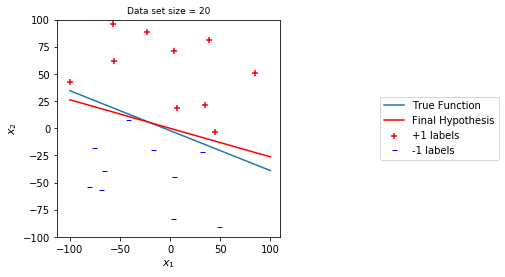

In [7]:
#perceptron(df.values, 2)

lb, ub = -100, 100
N, dim = 20, 2 
num_grid_points = 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 100
use_adaline, randomize = False, False
_, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

#### Exercise 1.5
1. (a) Learning
1. (b) Design
1. (c) Learning
1. (d) Design
1. (e) Learning

#### Exercise 1.6
1. (a) Supervised Learning
1. (b) Reinforcement Learning
1. (c) Unsupervised Learning
1. (d) Learning to play music
  * If learn by yourself, it's unsupervised learning
  * If learn from a teacher, it's supervised learning
  * If learn by yourself but with someone to tell you if your music is good or not, it's reinforcement learning. 
1. (e) Supervised Learning

#### Exercise 1.7
1. (a) The learning algorithm will pick the final hypothesis that always returns 1. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points. 
1. (b) The learning algorithm will pick the final hypothesis that always returns 0. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (c) The learning algorithm will pick the final hypothesis $XOR$. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (d) The learning algorithm will pick the final hypothesis $f_7$. 
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
  
#### Exercise 1.8

In a sample of 10 marbles, for the fraction $\nu$ of red marbles to be $\nu \le 0.1$, we must have at most one red marbles. 

\begin{align*}
P(number\;of\;red \le 1) &= P(red = 0) + P(red = 1) \\
&= (1-\mu)^{10} + \mu (1-\mu)^9\\
&= (1-\mu)^9\\
&= 1.0e-9
\end{align*}

#### Exercise 1.9
We have $\mu=0.9$, $N=10$, and want $\nu \le 0.1$, i.e. $|\mu - \nu| = \mu - \nu \ge 0.9 - 0.1 = 0.8$. Let's pick $\epsilon = 0.7$, then according to Hoeffding Inequity, we have

\begin{align*}
P(\nu \le 0.1) &= P(\mu - \nu \ge 0.8)\\
&= P(|\mu - \nu| \ge 0.8) \\
&\le P(|\mu - \nu| \gt 0.7) \\
&= P(|\mu - \nu| \gt \epsilon) \\
&\le 2e^{-2\epsilon^2N}\\
&\approx 0.0001109032
\end{align*}

This is an upper bound of the probability from pervious problem and is much larger than the calculated probability.


#### Exercise 1.10
1. (a) The $\mu$ for the three coins are all $0.5$ since the coins are fair.

In [70]:
# Exercise 1.10 (a) 
total_coins = 1000
total_flips = 10
run_once(total_coins, total_flips, True)

Frequency of first coin: 0.5
Frequency of a random coin: id(83)-freq(0.3)
Frequency of the coin with minimum frequency: id(7)-freq(0.0)


(0.5, 0.3, 0.0)

(array([6.23941e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.76049e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <a list of 10 Patch objects>)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


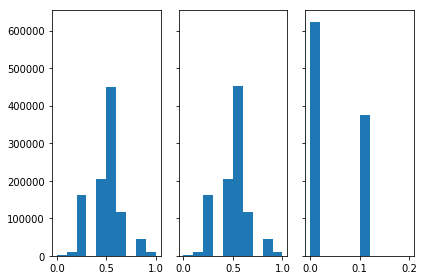

In [56]:
# Exercise 1.10 (b) 
total_coins = 1000
total_flips = 10
total_runs = 1000000
v1s, vrands, vmins = [],[],[]
for run in range(total_runs):
    v1,vrand,vmin = run_once(total_coins, total_flips)
    v1s.append(v1)
    vrands.append(vrand)
    vmins.append(vmin)

fig, axs = plt.subplots(1,3,sharey=True, tight_layout=True)
n_bins = 10
axs[0].hist(v1s,bins=n_bins)
axs[1].hist(vrands,bins=n_bins)
axs[2].hist(vmins,bins=n_bins)

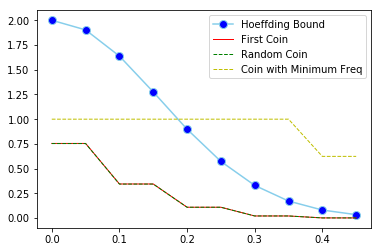

In [65]:
# Exercise 1.10 (c)
eps = np.arange(0.0,0.5,0.05)
bounds = hoeffding_bound(eps, total_flips)
v1s, vrands, vmins = np.array(v1s), np.array(vrands), np.array(vmins)
v1d = np.abs(v1s-0.5)
vrandd = np.abs(vrands-0.5)
vmind = np.abs(vmins-0.5)

p1, prand, pmin = np.zeros(len(eps)),np.zeros(len(eps)),np.zeros(len(eps))

for idx in range(eps.shape[0]):
    ep = eps[idx]
    p1[idx] = np.sum(v1d > ep)/total_runs
    prand[idx] = np.sum(vrandd > ep)/total_runs
    pmin[idx] = np.sum(vmind > ep)/total_runs

#plt.ylim((0,0.01))    
plt.plot(eps, bounds, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', label='Hoeffding Bound')
plt.plot(eps, p1, marker='', color='r', linewidth=1, label='First Coin')
plt.plot(eps, prand, marker='', color='g', linewidth=1, linestyle='dashed', label='Random Coin')
plt.plot(eps, pmin, marker='', color='y', linewidth=1, linestyle='dashed', label='Coin with Minimum Freq')
plt.legend()

#### Exercise 1.10
1. (d) The first and random coins follow the Hoeffding bound. The coin with minimum frequency doesn't obey Hoeffding bound. This is because that for the first two coins, the coins were chosen before the experiment. While for the last one, we have to flip all the coins first, and use the data to compute out which is the coin with minimum frequency of heads. This violates the Hoeffding inequality condition which says the hypothesis $h$ has been fixed before samples were drawn.

1. (e) When we choose the coin having the minimum frequency of heads. We are like choosing the bin from 1000 bins (our hypothesis space). But we choose bin after we finish sampling the data.  This is akin to learning algorithm for the final hypothesis. The other two coins were chosen before the sampling, which is choosing bin beforehand.

#### Exercise 1.11

1. (a) $S$ can not produce a hypothesis that is guaranteed to perform better than random on any point outside $\mathcal{D}$. 
If $f$ has 25 $+1$ on $\mathcal{D}$ but $-1$ on all other points in $\mathcal{X}$, $S$ will choose the hypothesis $h_1$, which will not match $f$ outside of $\mathcal{D}$ at all. On the other hand, a random function will have $+1$ and $-1$ 50/50, and it matches $f$ half of time, which is better than the function produced by $S$.

1. (b) It is possible that $C$ produces a better hypothesis than $S$ produces. See the example above.
1. (c) If every point in $\mathcal{D}$ has 1, then $S$ will choose $h_1$ and $C$ will choose $h_2$. So outside of $\mathcal{D}$, $h_1$ will have 90% chance to match with $f$, while $h_2$ will have only 10% chance. $S$ will always produce a better hypothesis than $C$. 

1. (d) From previous problem, we can see that when $p \lt 0.5$, $C$ will produce a better hypothesis than $S$. Since $C$ always produce $h_2$, which will match $f$ better than $h_1$ if $p \lt 0.5$.

#### Exercise 1.12

I think the best I can promise is (c). 
* The unknown target $f$ can be very complex that we can't learn at all.
* If we can learn and produce a hypothesis $g$, since there are many data points (4000), the probability that $g$ matches $f$ is high according to Hoeffding inequality, and the error on $g$ might be small since we have a large data set.

#### Exercise 1.13

1. (a) The probability of error that $h$ makes in approximating $y$ is

\begin{align*}
P(h \ne y) &= P(h \ne y| y = f(x))P(y=f(x)) + P(h\ne y| y \ne f(x))P(y\ne f(x))\\
&= \mu \lambda + (1-\mu)(1-\lambda)\\
&= \mu (2 \lambda - 1) + (1-\lambda)\\
\end{align*}

1. (b) It can be seen from previous problem, that when $\lambda = 0.5$, $P(h\ne y) = 1-\lambda = 0.5$, is independent of $\mu$.